In [8]:
# Import
from Diffusion import *
from utils import makedir
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime
import h5py as h5

In [9]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_path = local_storage_dir + "Datasets/IntensityFrontier/if-image-train.h5"
checkpoint_dir = local_storage_dir + "Checkpoints/IntensityFrontier/"
log_dir = local_storage_dir + "Logs/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(gif_dir)
num_channels = 1 # 1 for grayscale
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 128
batch_size = 64

In [16]:
# Load dataset
class hdf5Dataset(Dataset):
    def __init__(self, dataset_path, load_all=False, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.load_all = load_all
        if load_all:
            self.dataset = h5.File(dataset_path, 'r')['image'][:]
            self.dataset = self.dataset[:,None,:,:]
            self.dataset = torch.from_numpy(self.dataset).float()
        else:
            self.dataset = h5.File(dataset_path, 'r')['image']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.load_all:
            image = self.dataset[idx]
        else:
            image = self.dataset[idx][None,:,:]
            image = torch.from_numpy(image).float()
        if self.transform:
            image = self.transform(image)
        return image        

transform = transforms.Resize((image_size, image_size), antialias=True)

image_dataset = hdf5Dataset(dataset_path, load_all=False, transform=transform)
dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=24, pin_memory=True, persistent_workers=True)

In [17]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

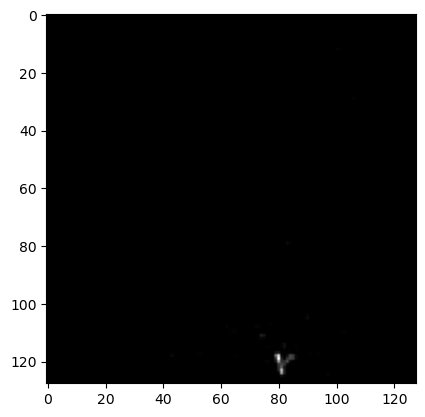

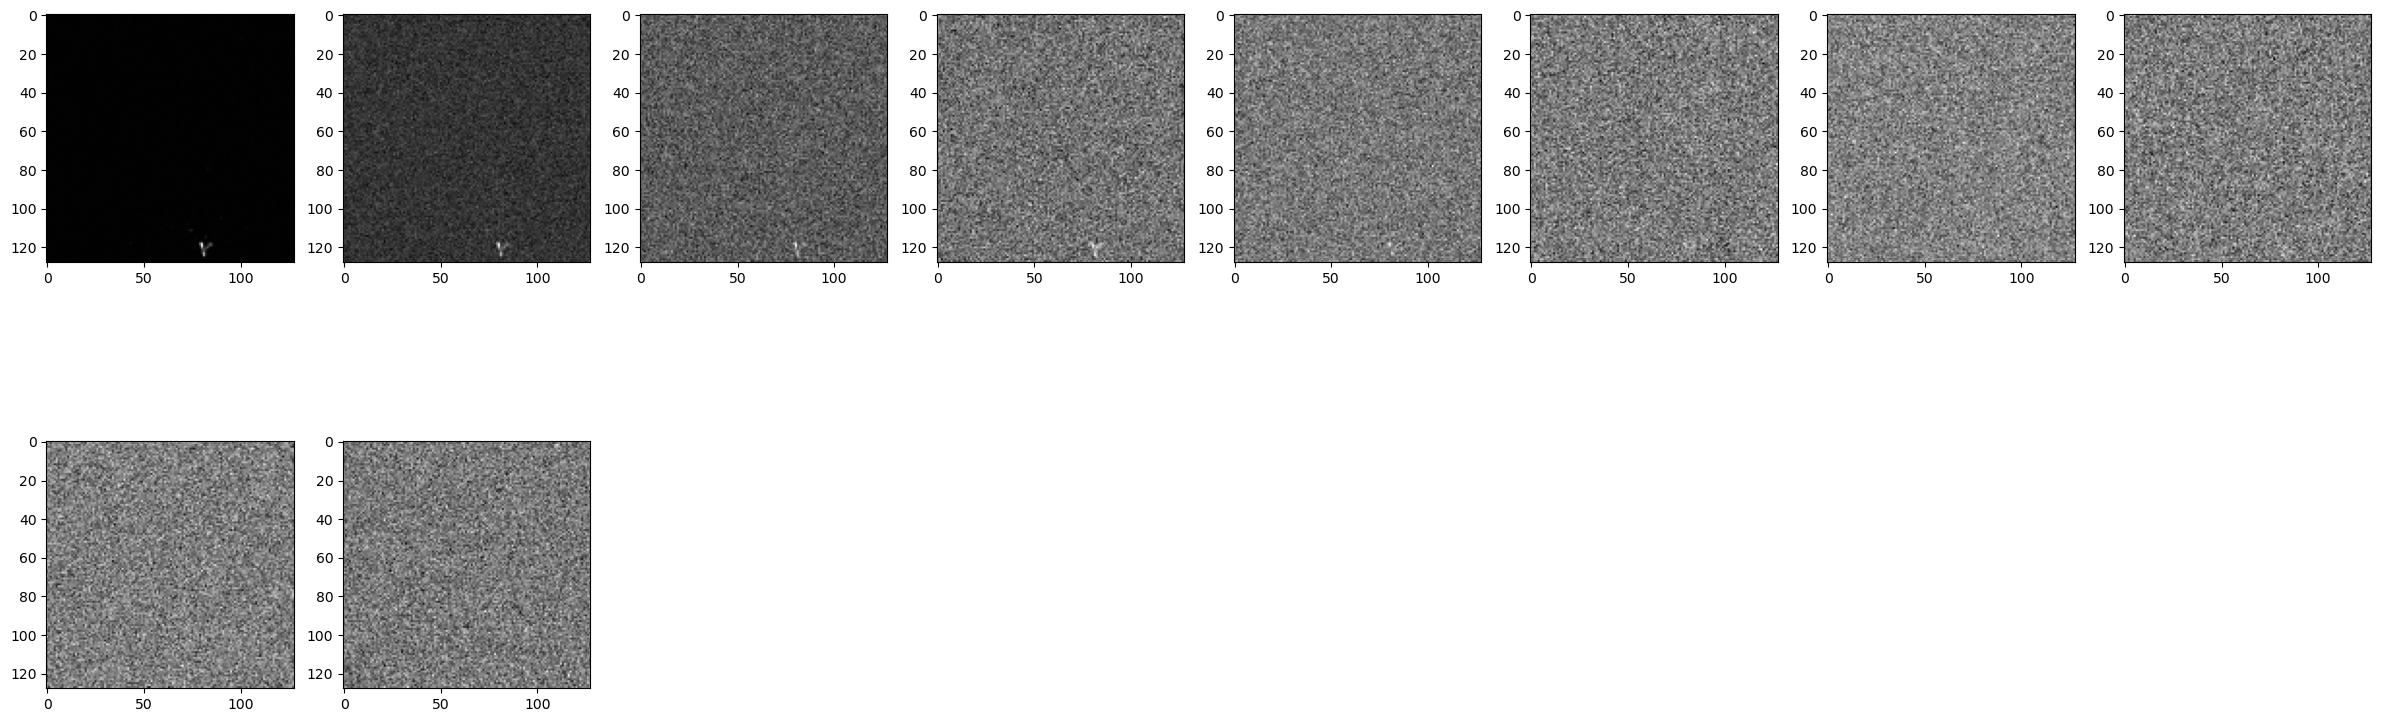

In [18]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.float32)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]), cmap='gray')

plt.figure(figsize=(30,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for idx in range(0, num_timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
    plt.imshow(image_from_tensor(tensor[0]), cmap='gray')

In [19]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=64,
    num_downsamples=5,
    num_mid_convs=1
    )
print("Num params: ", sum(p.numel() for p in model.parameters()))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, last_epoch=-1, verbose=False)

Num params:  235894529


In [7]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = False
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model, optimizer, lr_scheduler)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=40,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=1,
    log_dir=log_dir+timestamp
    )

  0%|          | 0/6250 [00:00<?, ?it/s]/home/md775/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|          | 0/6250 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [20]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/md775/LocalStorage/MLProjects/Diffusion/Checkpoints/IntensityFrontier/model_min_loss.pt'

In [ ]:
# Visualize reverse process
plt.figure(figsize=(60,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for i, tensor in enumerate(tensor_sample[0]):
    if i % stepsize == 0:
        plt.subplot(int(num_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor), cmap='gray')

plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensor_sample[-1][-1]), cmap='gray')

In [ ]:
# Create gif
from PIL import Image
images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t,tensor in enumerate(tensor_sample):
    if t % stepsize == 0:
        image_array = image_from_tensor(tensor).astype(np.uint8)
        image = Image.fromarray(image_array).convert('RGB')
        images.append(image)
images[0].save(os.getcwd() + '/samples/particles.gif', save_all=True, append_images=images[1:], duration=50)